## Created by Jessie McDonald and used in Mcdonald and Weiss 2021. Optimized for PERiLS data by Joshua Ostaszewski and used in Ostaszewski et al. 2025.

In [1]:
import pandas as pd
import datetime as dt
from functions import calc_dewpoint, calc_thetae, calc_thetav
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import cmocean
import matplotlib.lines as mlines
from metpy import interpolate
from scipy.stats import stats
from metpy.plots import  StationPlot
import matplotlib.patheffects as path_effects
import matplotlib.transforms as mtransforms
pe= [path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()]
import geopandas as gpd
from scipy.interpolate import griddata
from matplotlib.dates import date2num, num2date, HourLocator,DateFormatter,MinuteLocator
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import pickle
from collections import OrderedDict
    
%pylab inline
%config InlineBackend.figure_format='retina'

# # new storm motions calculated 7 April 2020. Use this from now on
SNSfile = '/Volumes/JoshDrive/PERiLS_Y1/Excel_SN/After_CPA/IOP2_Grad_Analysis.csv'
sns = pd.read_csv(SNSfile)

sns = sns.rename(columns={"TV_dist": "TV", "TE_dist": "TE"})
sns = sns[sns['TOA_coldpool_final'].notna()]

import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# StickNet Measurements from IOP2

This dataset summarizes various parameters collected during Intensive Observing Period 2 (IOP2). Each row represents an individual StickNet observation and includes information on deployment, storm characteristics, and derived thermodynamic values.

---

### **Basic Information**
- **IOP, Date, ID, Lat, Lon** — Identifiers and location metadata.
- **array_type** — Deployment type: `Coarse` or `Fine` array.
- **mode** — Storm mode observed: e.g., `Mesovortex`, `Hybrid`, etc.
- **MC_rel_toa** — Indicates if the StickNet measured a supercell relative to the Time of Arrival (TOA).

---

### **Storm Proximity & Type**
- **MV_H_dist** — Horizontal distance (in km) from StickNet to mesovortex.
- **type** — Vortex classification: `R` = Rotating, `NR` = Non-Rotating.
- **tor** — Tornado association: `NT`, `TOT`, `Pre-tornadic`, or `Post-tornadic`.
- **Directionality** — StickNet position relative to the mesovortex: `North` or `South`.

---

### **Time of Arrival (TOA) Estimations**
- **TOA_coldpool** — Estimated TOA based on WSR-88D reflectivity (UTC).
- **TOA_coldpool_final** — Final TOA based on 1-min decrease in virtual potential temperature (θ<sub>v</sub>).
- **TOA_mods, SM_mods, ref_mods, BS_mods** — Subjective adjustments to TOA, storm motion, reflectivity contour/angle, and base state calculations.
- **Threshold** — θ<sub>v</sub> threshold (in K) used to define TOA (`-3`, `-2`, or `-1` K).

---

### **Storm Motion Components**
- **U, V** — U- and V-components of storm motion near TOA.
- **U6, V6, U12, V12, U20, V20, U26, V26** — Storm motion at various times for fine-scale array *(typically disregarded)*.

---

### **Reflectivity-Based Gradients**
- **ref_angle** — Reflectivity gradient angle used as a proxy for the θ<sub>v</sub> gradient.
- **ref_contour** — Reflectivity contour used to determine `ref_angle`.

---

### **Thermodynamic Spatial Deficits**
- **TE_dist** — Spatial theta-e (θ<sub>e</sub>) deficit.
- **TV_dist** — Spatial theta-v (θ<sub>v</sub>) deficit.
- **dTVdn** — Spatial θ<sub>v</sub> gradient.

---

### **Base-State Thermodynamics**
- **Tdd_BS** — Base-state dewpoint depression.
- **TE_BS** — Base-state theta-e (θ<sub>e</sub>).
- **TV_BS** — Base-state theta-v (θ<sub>v</sub>).


In [2]:
sns

,IOP,date,ID,lat,lon,array_type,mode,MC_rel_toa,MV_H_dist,type,...,ref_contour,SM_mods,ref_mods,BS_mods,TE,TV,dTVdn,Tdd_BS,TE_BS,TV_BS
0,2,3/30/2022,101A,33.890050,-89.019192,Coarse,Mesovortex,NaN,4,R,...,46,NaN,NaN,NaN,-11.12,-7.16,-3.24,5.49,333.34,299.26
1,2,3/30/2022,102A,33.167592,-88.539054,Coarse,Mesovortex,NaN,8,R,...,40,NaN,NaN,NaN,-8.17,-3.26,-0.87,1.13,330.65,295.27
2,2,3/30/2022,103A,33.714987,-88.450477,Fine,Mesovortex,NaN,15,R,...,43,NaN,NaN,NaN,-8.76,-3.64,-1.29,1.98,335.48,297.39
3,2,3/30/2022,104A,33.818643,-88.461089,Fine,Mesovortex,NaN,2,R,...,43,1.0,1.0,NaN,-6.88,-3.44,-2.20,2.70,334.45,297.55
4,2,3/30/2022,105A,33.535339,-89.124273,Coarse,Mesovortex,NaN,13,R,...,40,NaN,NaN,NaN,-5.53,-4.80,-1.17,5.23,335.19,299.74
5,2,3/30/2022,106A,33.888094,-88.729118,Coarse,Mesovortex,NaN,5,R,...,40,NaN,NaN,NaN,-5.99,-4.29,-1.58,4.01,334.27,298.45
6,2,3/30/2022,107A,33.588088,-88.666433,Coarse,Mesovortex,NaN,9,R,...,43,NaN,NaN,NaN,-9.29,-4.22,-1.29,2.78,334.45,297.58
7,2,3/30/2022,108A,34.178948,-89.032192,Coarse,Mesovortex,NaN,1,R,...,40,NaN,NaN,NaN,-6.95,-4.43,-1.09,3.33,338.20,299.59
8,2,3/30/2022,109A,34.267943,-88.767288,Coarse,Mesovortex,NaN,7,R,...,45,NaN,-1.0,NaN,-10.01,-5.82,-2.81,4.67,336.70,299.87
9,2,3/30/2022,110A,33.757437,-88.445230,Fine,Mesovortex,NaN,10,R,...,40,NaN,NaN,NaN,-7.75,-3.15,-1.12,1.89,333.82,296.84


## Scale bar adjustments for fine or coarse array below

In [3]:
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=5, fontsize=15):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    
    edited by Jessie. Found on GitHub - https://github.com/SciTools/cartopy/issues/490
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    # the edge is the black lines in between and extending on the edges of the white and gray parts
    # sbx is the center. length * 500 == half the length
    
    # NOTE: in x-direction, ADDING a value moves it right, SUBTRACTING a value moves it left


############################################## CHANGE BELOW ########################################################
    
####FOR FULL OBAN    
    edge = 500
    bar_xs = [sbx - length * 500 - edge, sbx + length * 500 +edge]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth+4,solid_capstyle="butt", clip_on=False)  # background

    #add colors - 4 colors
    x1, x2, x3, x4, x5 = sbx-length*500, sbx -length*250, sbx, sbx+length*250, sbx+length*500
    ax.plot([x1,x2-edge/2], [sby, sby], transform=tmc, color='w', linewidth=linewidth,solid_capstyle="butt", clip_on=False)
    ax.plot([x2+edge/2,x3-edge/2] ,[sby, sby], transform=tmc, color='gray', linewidth=linewidth,solid_capstyle="butt", clip_on=False)
    ax.plot([x3+edge/2,x4-edge/2] ,[sby, sby], transform=tmc, color='w', linewidth=linewidth,solid_capstyle="butt", clip_on=False)
    ax.plot([x4+edge/2,x5] ,[sby, sby], transform=tmc, color='gray', linewidth=linewidth,solid_capstyle="butt", clip_on=False)
    # add "km", center point, and end point
    y_lift = linewidth*10
    ax.text(x3, sby+length*y_lift , str(int(round(length/2))), transform=tmc,
                    horizontalalignment='center', verticalalignment='bottom',
                    color='k', fontsize=fontsize, fontweight='bold')
    ax.text(x5-length*50, sby+length*y_lift , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color='k', fontsize=fontsize, fontweight='bold')
    ax.text(x1+length*90, sby+length*y_lift , 'km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color='k', fontsize=fontsize, fontweight='bold')


#### FOR FINESCALE
    # Set the edge and x-coordinates for the scale bar
    # edge = 500
    # bar_xs = [sbx - length * 500 - edge, sbx + length * 500 + edge]

    # # Plot the background scale bar (black line)
    # ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth+4, solid_capstyle="butt", clip_on=False) 

    # # Add alternating colors - 4 segments (white, gray, white, gray)
    # x1, x2, x3, x4, x5 = sbx - length * 500, sbx - length * 250, sbx, sbx + length * 250, sbx + length * 500

    # # White segment (leftmost)
    # ax.plot([x1-400, x2 - 275], [sby, sby], transform=tmc, color='w', linewidth=linewidth, solid_capstyle="butt", clip_on=False)

    # # Gray segment
    # ax.plot([x2-175, x3-50], [sby, sby], transform=tmc, color='gray', linewidth=linewidth, solid_capstyle="butt", clip_on=False)

    # # White segment
    # ax.plot([x3 + 50, x4 +175], [sby, sby], transform=tmc, color='w', linewidth=linewidth, solid_capstyle="butt", clip_on=False)

    # # Gray segment (rightmost)
    # ax.plot([x4 + 275, x5+400], [sby, sby], transform=tmc, color='gray', linewidth=linewidth, solid_capstyle="butt", clip_on=False)

    # add "km", center point, and end point
    # y_lift = linewidth*10
    # ax.text(x3, sby+length*y_lift , str(int(round(length/2))), transform=tmc,
    #                 horizontalalignment='center', verticalalignment='bottom',
    #                 color='k', fontsize=fontsize, fontweight='bold')
    # ax.text(x5-length*50, sby+length*y_lift , str(round(length)), transform=tmc,
    #         horizontalalignment='center', verticalalignment='bottom',
    #         color='k', fontsize=fontsize, fontweight='bold')
    # ax.text(x1+length*90, sby+length*y_lift , 'km', transform=tmc,
    #         horizontalalignment='center', verticalalignment='bottom',
    #         color='k', fontsize=fontsize, fontweight='bold')


## Set up projection and boundaries for T-S plots

In [4]:
# Set up our projection
crs = ccrs.PlateCarree()
globe = ccrs.Globe(datum='WGS84',ellipse='sphere')

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')


#######Change for each IOP (e.g., IOP2) or if just wanting zoomed into the fine scale array (IOP2_fine)

#IOP1
# llcrnrlon=-89.17
# llcrnrlat=32.41
# urcrnrlon=-87.82
# urcrnrlat=33.64

# west_lon, east_lon = -89.17, -87.82
# north_lat, south_lat=33.64, 32.41

#IOP2
llcrnrlon=-89.17
llcrnrlat=32.98
urcrnrlon=-87.87
urcrnrlat=34.32

west_lon, east_lon = -89.17, -87.87
north_lat, south_lat=34.32, 32.98

#IOP3
# llcrnrlon=-87.4
# llcrnrlat=31.92
# urcrnrlon=-86.27
# urcrnrlat=32.8

# west_lon, east_lon = -87.40, -86.27
# north_lat, south_lat=32.80, 31.92

#IOP4
# llcrnrlon=-90.56
# llcrnrlat=35.65
# urcrnrlon=-89.01
# urcrnrlat=36.96

# west_lon, east_lon = -90.56, -89.01
# north_lat, south_lat=36.96, 35.65

#IOP5
# llcrnrlon=-91.26
# llcrnrlat=35.20
# urcrnrlon=-90.03
# urcrnrlat=36.18

# west_lon, east_lon = -91.26, -90.03
# north_lat, south_lat=36.18, 35.20

#IOP2_fine
# west_lon=-88.6
# south_lat=33.65
# east_lon=-88.3
# north_lat=33.95

# llcrnrlon=-88.6
# llcrnrlat=33.65
# urcrnrlon=-88.3
# urcrnrlat=33.95

#IOP3_fine
# west_lon=-86.5
# south_lat=32.05
# east_lon=-86.2
# north_lat=32.45

# llcrnrlon=-86.5
# llcrnrlat=32.05
# urcrnrlon=-86.2
# urcrnrlat=32.45

#IOP_Hybrid
# west_lon=-86.7
# south_lat=32.2
# east_lon=-86.1
# north_lat=32.8

# llcrnrlon=-86.7
# llcrnrlat=32.2
# urcrnrlon=-86.1
# urcrnrlat=32.8

#IOP4 Fine
# west_lon=-89.9
# south_lat=36
# east_lon=-89.6
# north_lat=36.3

# llcrnrlon=-89.9
# llcrnrlat=36
# urcrnrlon=-89.6
# urcrnrlat=36.3

#IOP5 Fine
# west_lon=-90.95
# south_lat=35.45
# east_lon=-90.45
# north_lat=35.7

# llcrnrlon=-90.95
# llcrnrlat=35.45
# urcrnrlon=-90.45
# urcrnrlat=35.7

#lon_add, lat_add
LL = (west_lon),(north_lat)
UR = (east_lon ),(south_lat)
LL = crs.transform_point((west_lon),(north_lat),ccrs.PlateCarree())
UR = crs.transform_point((east_lon ),(south_lat),ccrs.PlateCarree())


### Make interpolation grids for the TOA based on StickNet locations

In [5]:
sns = sns.set_index(sns['ID'])
lats =        sns['lat'].values
lons =        sns['lon'].values
te_deficits = np.asarray(sns['TE'].values)
tv_deficits = np.asarray(sns['TV'].values)
dTVdn =       np.asarray(sns['dTVdn'].values)
toas =        pd.to_datetime(sns['TOA_coldpool_final'].values)

#####CHANGE FOR EACH IOP###################################

#IOP1
# xi,yi = np.linspace(-89.17,-87.82,40),np.linspace(32.41,33.64,40)
# X,Y = np.meshgrid(xi,yi)
# time_grid= griddata((lons,lats),date2num(toas),(X,Y))

#IOP2
xi,yi = np.linspace(-89.17,-87.87,40),np.linspace(32.98,34.32,40)
X,Y = np.meshgrid(xi,yi)
time_grid= griddata((lons,lats),date2num(toas),(X,Y))

# #IOP3
# xi,yi = np.linspace(-87.4,-86.27,40),np.linspace(31.92,32.8,40)
# X,Y = np.meshgrid(xi,yi)
# time_grid= griddata((lons,lats),date2num(toas),(X,Y))

#IOP3
# xi,yi = np.linspace(-87.4,-86.27,40),np.linspace(31.92,32.8,40)
# X,Y = np.meshgrid(xi,yi)
# time_grid= griddata((lons,lats),date2num(toas),(X,Y))

#IOP4
# xi,yi = np.linspace(-90.56,-89.01,40),np.linspace(35.65,36.96,40)
# X,Y = np.meshgrid(xi,yi)
# time_grid= griddata((lons,lats),date2num(toas),(X,Y))

#IOP5
# xi,yi = np.linspace(-91.26,-90.03,40),np.linspace(35.20,36.18,40)
# X,Y = np.meshgrid(xi,yi)
# time_grid= griddata((lons,lats),date2num(toas),(X,Y))

## Set up cold pool value ranges for T-S plot

In [6]:
def rgb(hexcol):
    return matplotlib.colors.to_rgba(hexcol)

def plot_options(var):
    '''options include all named variables '''
    
    if var == 'te_deficits':
        mycmap = cmocean.cm.deep_r
        
        levels = np.arange(-18, 0, .25)
        
        clabel = 'K'
        title = r'30-min ${\theta_e}$ Deficits'
          
    elif var == 'tv_deficits':
        mycmap = cmocean.cm.tempo_r
        
        levels = np.arange(-9.5, 0.25, .25)
        
        clabel = 'K'
        title = r'30-min ${\theta_v}$ Deficits'
    
    elif var == 'dTVdn':
        mycmap = cmocean.cm.ice
        
        levels = np.arange(-5.6,-.1,0.1)
        
        clabel = r'K km${^{-1}}$'
        title = r'Maximum 3-min ${\theta_v}$ Change'
        
    levels = levels
    cbar_label = clabel
    return mycmap, title, levels, cbar_label

## Plotting various stuff onto T-S plot

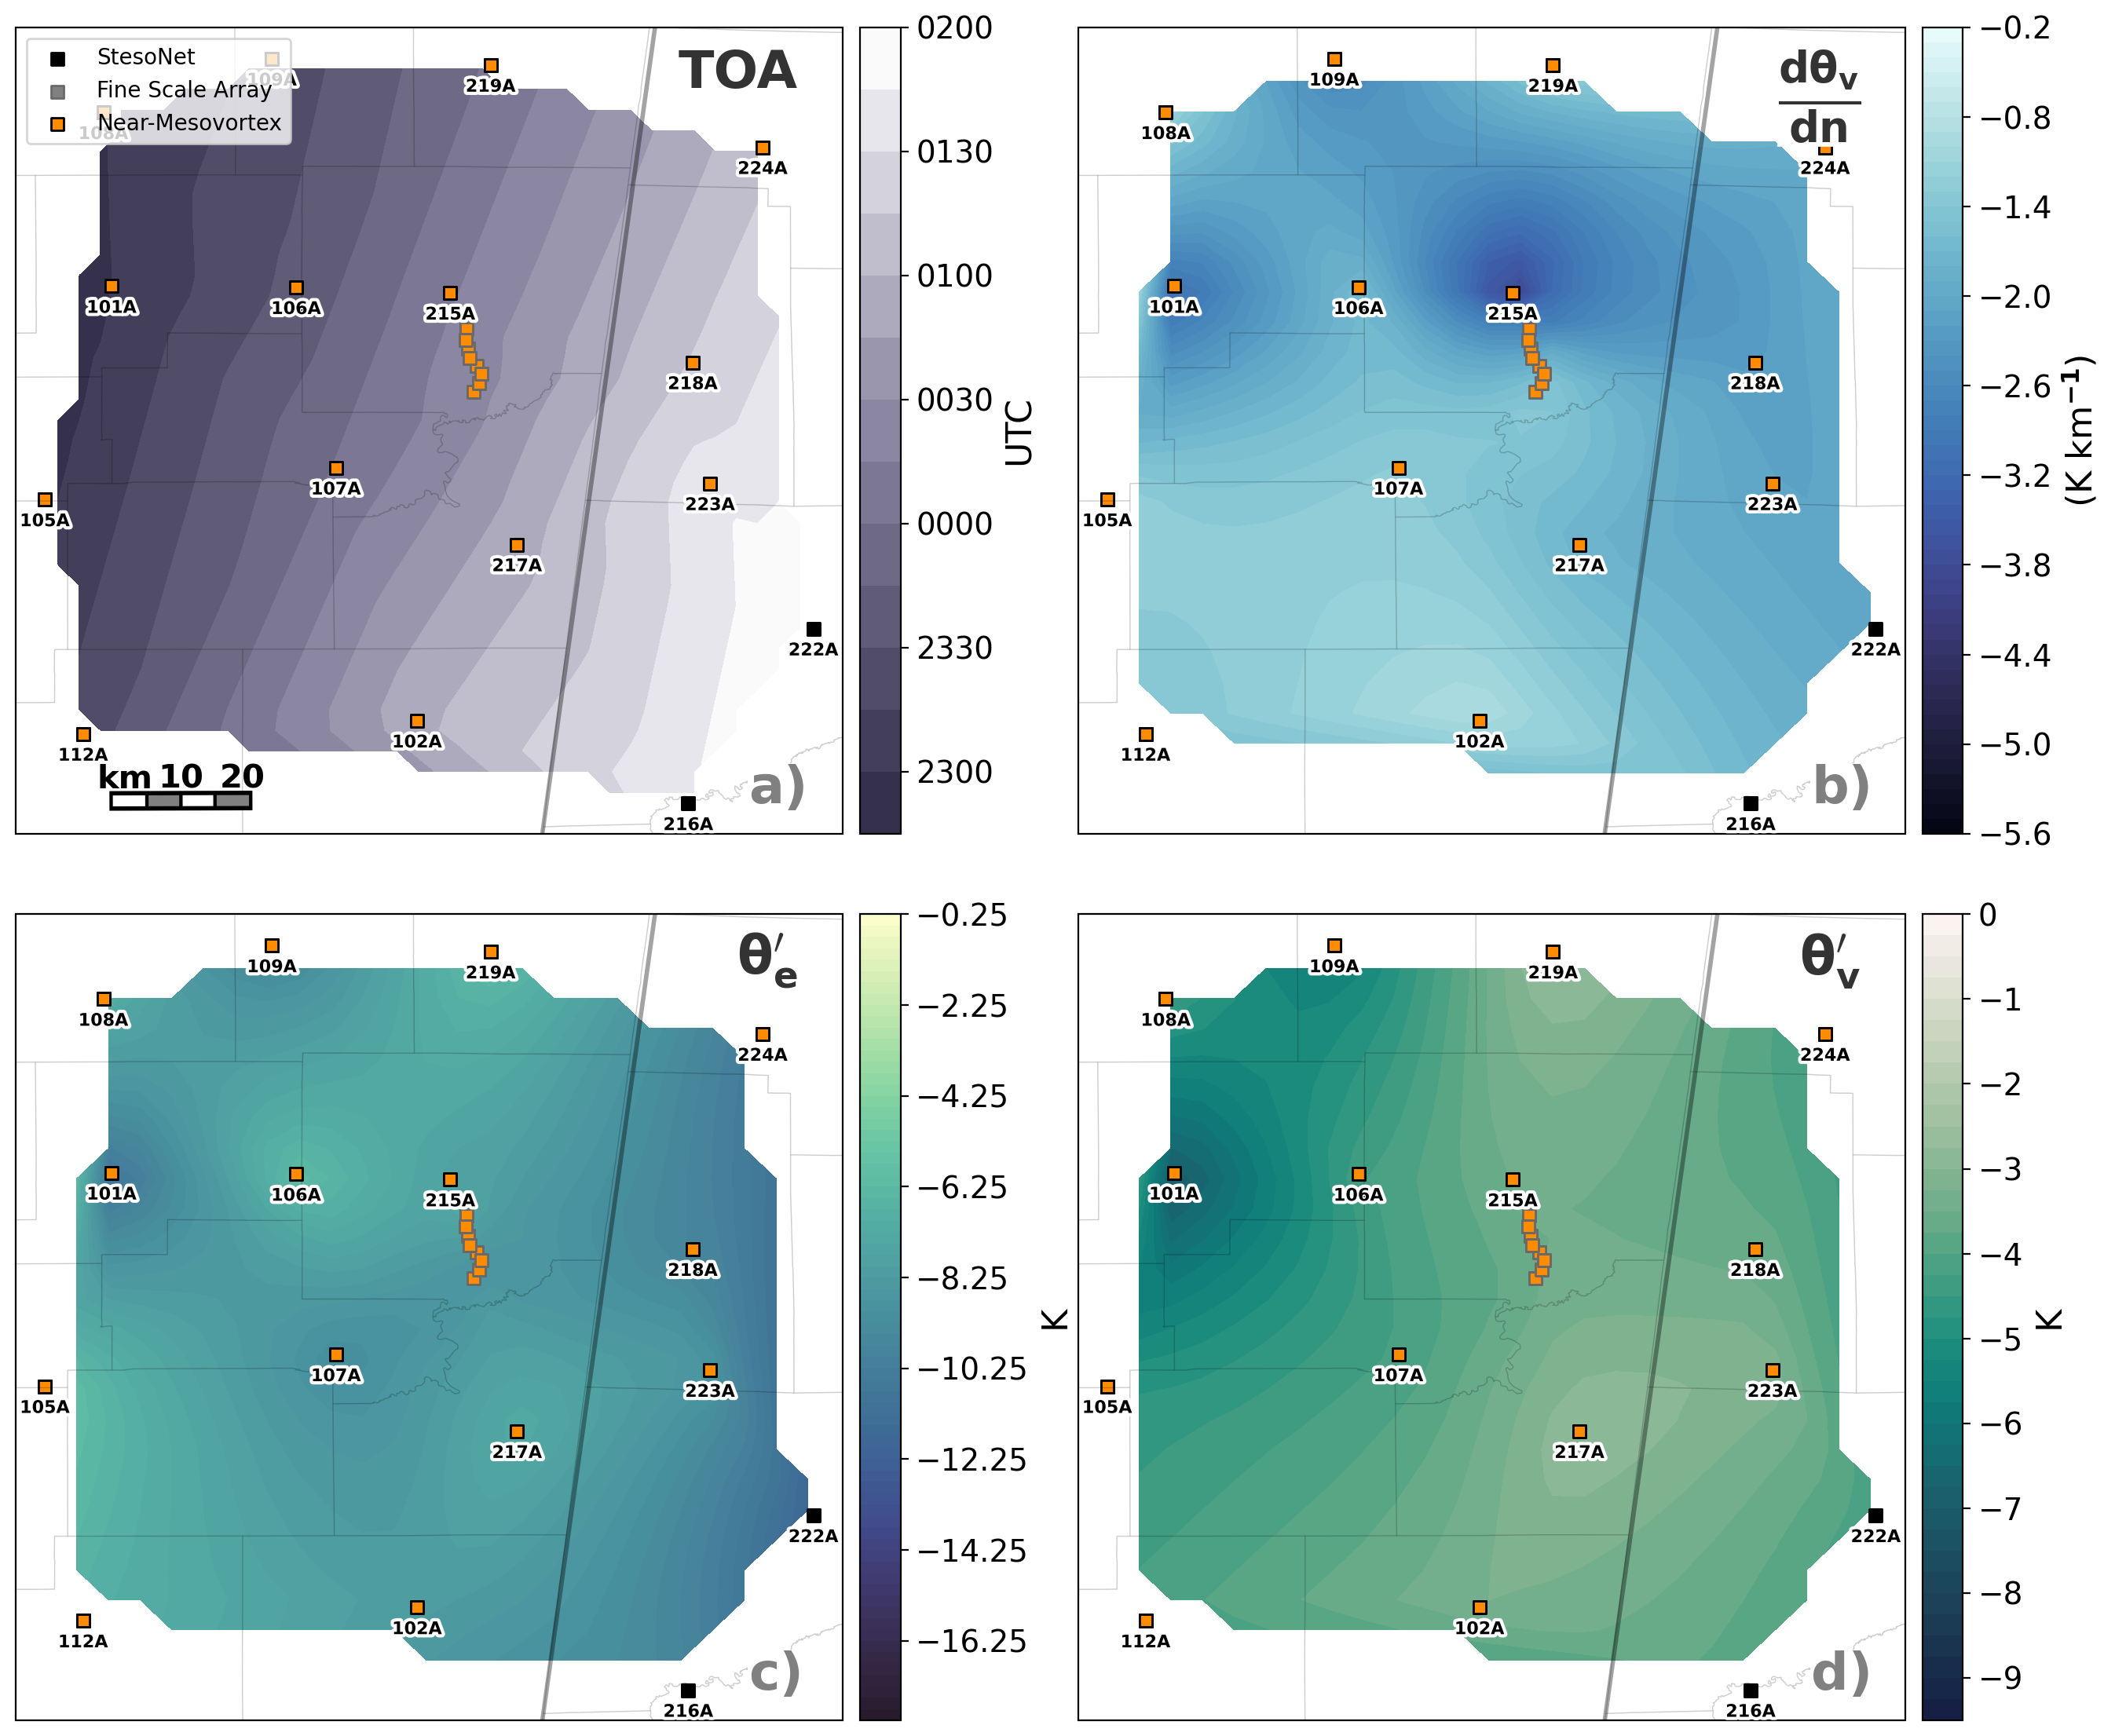

In [7]:
fig, axes = plt.subplots(2,2, figsize=(16, 14), subplot_kw={'projection': crs})

for ax in axes.flatten():
    ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs)
    ax.add_feature(states_provinces, edgecolor='k', alpha=0.2, linewidth=2)
    ax.add_feature(USCOUNTIES.with_scale('500k'), alpha=0.1, linewidth=0.5) # 20m, 5m 500k sizes from large to small
    
    coarse = sns.loc[sns.index[np.where((sns['array_type'] == 'Coarse')&(sns['mode'] != 'Mesocyclone'))]]                                                    # use 20m for testing, and 500k for final plots
    fine = sns.loc[sns.index[np.where((sns['array_type'] == 'Fine')&(sns['mode'] != 'Mesocyclone'))]]
    
    coarseMV = sns.loc[sns.index[np.where((sns['array_type'] == 'Coarse')&(sns['mode'] == 'Mesovortex'))]]                                                    # use 20m for testing, and 500k for final plots
    fineMV = sns.loc[sns.index[np.where((sns['array_type'] == 'Fine')&(sns['mode'] == 'Mesovortex'))]]
    
    ax.scatter(coarse['lon'].values, coarse['lat'].values, marker='s', color='k',edgecolors='k', transform=crs, label='StesoNet')
    ax.scatter(fine['lon'].values, fine['lat'].values, marker='s', color='grey',edgecolors='dimgrey', transform=crs, label='Fine Scale Array')
    ax.scatter(coarseMV['lon'].values, coarseMV['lat'].values, marker='s', color='darkorange',edgecolors='k', transform=crs, label='Near-Mesovortex')
    ax.scatter(fineMV['lon'].values, fineMV['lat'].values, marker='s', color='darkorange',edgecolors='dimgrey', transform=crs)
### Use for coarse+fine array plot
    stationplot1 = StationPlot(ax, coarse['lon'].values, coarse['lat'].values ,clip_on=True, transform=crs, fontsize=9, weight='bold')
    stationplot1.plot_text((0, -1.1), coarse['ID'], fontsize=8, weight='bold', path_effects=pe)
### Use for only fine array plot    
#     stationplot2 = StationPlot(ax, fine['lon'].values, fine['lat'].values ,clip_on=True, transform=crs, fontsize=9, weight='bold')
#     stationplot2.plot_text((0, -1.1), fine['ID'], fontsize=8, weight='bold', path_effects=pe)

    ax.set_aspect('auto')
    
      

##################### Change TIME = start to end of the IOP to make time-to-space conversion ##############################
##IOP1
#time_levels = date2num(np.arange(dt.datetime(2022,3,22,19,15), dt.datetime(2022,3,23,1), dt.timedelta(minutes=15)))
##IOP2
time_levels = date2num(np.arange(dt.datetime(2022,3,30,22,45), dt.datetime(2022,3,31,2,15), dt.timedelta(minutes=15)))
##IOP3
#time_levels = date2num(np.arange(dt.datetime(2022,4,5,14,15), dt.datetime(2022,4,5,16,15), dt.timedelta(minutes=15)))
##IOP4
#time_levels = date2num(np.arange(dt.datetime(2022,4,13,19,30), dt.datetime(2022,4,13,21,15), dt.timedelta(minutes=15)))
##IOP5
#time_levels = date2num(np.arange(dt.datetime(2023,4,5,15,45), dt.datetime(2023,4,5,18,15), dt.timedelta(minutes=15)))


######## Plot TOA subplot
colors = [rgb('#ffffff'),rgb('#8984a1'), rgb('#312c47')][::-1]
mycmap = LinearSegmentedColormap.from_list('name', colors, N=50)
grid = axes[0,0].contourf(X, Y, time_grid,cmap=mycmap, levels=time_levels)
axes[0,0].scatter(coarse['lon'].values, coarse['lat'].values, marker='s', color='k',edgecolors='k', transform=crs, label='StesoNet')
axes[0,0].scatter(fine['lon'].values, fine['lat'].values, marker='s', color='grey',edgecolors='dimgrey', transform=crs, label='Fine Scale Array')
axes[0,0].scatter(coarseMV['lon'].values, coarseMV['lat'].values, marker='s', color='darkorange',edgecolors='k', transform=crs, label='Near-Mesovortex')
axes[0,0].scatter(fineMV['lon'].values, fineMV['lat'].values, marker='s', color='darkorange',edgecolors='dimgrey', transform=crs)
#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[0,0], fraction=0.046, pad=0.02,
                    format=DateFormatter('%H%M'),ticks=MinuteLocator(interval=30))
cbar.set_label('UTC', fontsize = 16)
cbar.ax.tick_params(labelsize=14)   
handles, labels =ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
axes[0,0].legend(by_label.values(), by_label.keys(),fontsize=10, loc=2, framealpha=0.8)


# for interpolation and plotting  
gxx = np.arange(np.min(lons), np.max(lons)+0.05, 0.05)
gyy = np.arange(np.min(lats), np.max(lats)+0.05, 0.05)
gx, gy = np.meshgrid(gxx, gyy)
    


######### Plot GRAD THETA V
var =dTVdn
mycmap, mytitle, levels, cbar_label = plot_options('dTVdn')
#interpolating the ALREADY time-to-space converted spatial theta-v gradients onto a cartesian grid with 0.05 deg resolution
img1 = interpolate.natural_neighbor_to_grid(np.asarray(lons),np.asarray(lats),np.asarray(var), gx, gy)
grid = axes[0,1].contourf(gx,gy,img1,cmap=mycmap, levels=levels )
axes[0,1].scatter(coarse['lon'].values, coarse['lat'].values, marker='s', color='k',edgecolors='k', transform=crs, label='StesoNet')
axes[0,1].scatter(fine['lon'].values, fine['lat'].values, marker='s', color='grey',edgecolors='dimgrey', transform=crs, label='Fine Scale Array')
axes[0,1].scatter(coarseMV['lon'].values, coarseMV['lat'].values, marker='s', color='darkorange',edgecolors='k', transform=crs, label='Near-Mesovortex')
axes[0,1].scatter(fineMV['lon'].values, fineMV['lat'].values, marker='s', color='darkorange',edgecolors='dimgrey', transform=crs)
#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[0,1], fraction=0.046, pad=0.02)
cbar.set_label(r'(K km$\mathbf{^{-1}}$)', fontsize = 16)
cbar.ax.tick_params(labelsize=14)         
             
        
######### Plot THETA E
var =te_deficits
mycmap, mytitle, levels, cbar_label = plot_options('te_deficits')
#interpolating the ALREADY time-to-space converted spatial theta-e deficits onto a cartesian grid with 0.05 deg resolution
img1 = interpolate.natural_neighbor_to_grid(np.asarray(lons),np.asarray(lats),np.asarray(var), gx, gy)
grid = axes[1,0].contourf(gx,gy,img1,cmap=mycmap, levels=levels )
axes[1,0].scatter(coarse['lon'].values, coarse['lat'].values, marker='s', color='k',edgecolors='k', transform=crs, label='StesoNet')
axes[1,0].scatter(fine['lon'].values, fine['lat'].values, marker='s', color='grey',edgecolors='dimgrey', transform=crs, label='Fine Scale Array')
axes[1,0].scatter(coarseMV['lon'].values, coarseMV['lat'].values, marker='s', color='darkorange',edgecolors='k', transform=crs, label='Near-Mesovortex')
axes[1,0].scatter(fineMV['lon'].values, fineMV['lat'].values, marker='s', color='darkorange',edgecolors='dimgrey', transform=crs)
#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[1,0], fraction=0.046, pad=0.02)
cbar.set_label('K', fontsize = 16)
cbar.ax.tick_params(labelsize=14) 


######### Plot THETA V
var =tv_deficits
mycmap, mytitle, levels, cbar_label = plot_options('tv_deficits')
#interpolating the ALREADY time-to-space converted spatial theta-v deficits onto a cartesian grid with 0.05 deg resolution
img1 = interpolate.natural_neighbor_to_grid(np.asarray(lons),np.asarray(lats),np.asarray(var), gx, gy)
grid = axes[1,1].contourf(gx,gy,img1,cmap=mycmap, levels=levels )
axes[1,1].scatter(coarse['lon'].values, coarse['lat'].values, marker='s', color='k',edgecolors='k', transform=crs, label='StesoNet')
axes[1,1].scatter(fine['lon'].values, fine['lat'].values, marker='s', color='grey',edgecolors='dimgrey', transform=crs, label='Fine Scale Array')
axes[1,1].scatter(coarseMV['lon'].values, coarseMV['lat'].values, marker='s', color='darkorange',edgecolors='k', transform=crs, label='Near-Mesovortex')
axes[1,1].scatter(fineMV['lon'].values, fineMV['lat'].values, marker='s', color='darkorange',edgecolors='dimgrey', transform=crs)
#cbar must be last, or fraction call somehow messes everything up
cbar = plt.colorbar(grid, ax=axes[1,1], fraction=0.046, pad=0.02)
cbar.set_label('K', fontsize = 16)
cbar.ax.tick_params(labelsize=14)


# add plot type and plot label for publication
plot_labels = ['a)', 'b)', 'c)', 'd)']
plot_types = ['TOA', r'${\mathbf{\frac{d\theta_v}{dn}}}$',r'$\mathbf{\theta_e^{\prime}}$', 
              r'$\mathbf{\theta_v^{\prime}}$']

scale_bar(axes[0,0], 20, (0.2,0.04))

i=0
for ax in axes.flatten():
#IOP1
#     if i ==1: # grad tv
#         ax.text(-87.85,33.51,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, 
#                bbox=dict(facecolor='w',edgecolor='w', pad=0))
#     else:
#         ax.text(-87.85,33.56,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold',
#                bbox=dict(facecolor='w', edgecolor='w', pad=0))
#     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(.88, .11, plot_labels[i], transform=ax.transAxes + trans,
#             fontsize=24, verticalalignment='top', weight = 'bold', color='grey',
#             bbox=dict(facecolor='w', edgecolor='w', pad=0))
#IOP2
    if i ==1: # grad tv
        ax.text(-87.94,34.17,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, 
                bbox=dict(facecolor='w',edgecolor='w', pad=0))
    else:
        ax.text(-87.94,34.22,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold',
                bbox=dict(facecolor='w', edgecolor='w', pad=0))
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(.86, .1, plot_labels[i], transform=ax.transAxes + trans,
            fontsize=24, verticalalignment='top', weight = 'bold', color='grey',
            bbox=dict(facecolor='w', edgecolor='w', pad=0))
# # #IOP3
#     if i ==1: # grad tv
#         ax.text(-86.32,32.7,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, 
#                 bbox=dict(facecolor='w',edgecolor='w', pad=0))
#     else:
#         ax.text(-86.32,32.74,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold',
#                 bbox=dict(facecolor='w', edgecolor='w', pad=0))
#     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(.89, .1, plot_labels[i], transform=ax.transAxes + trans,
#             fontsize=24, verticalalignment='top', weight = 'bold', color='grey',
#             bbox=dict(facecolor='w', edgecolor='w', pad=0))
#IOP4
#     if i ==1: # grad tv
#         ax.text(-89.02,36.83,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, 
#                 bbox=dict(facecolor='w',edgecolor='w', pad=0))
#     else:
#         ax.text(-89.02,36.88,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold',
#                 bbox=dict(facecolor='w', edgecolor='w', pad=0))
#     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(.88, .1, plot_labels[i], transform=ax.transAxes + trans,
#             fontsize=24, verticalalignment='top', weight = 'bold', color='grey',
#             bbox=dict(facecolor='w', edgecolor='w', pad=0))
#IOP5
#     if i ==1: # grad tv
#         ax.text(-90.04,36.05,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, 
#                 bbox=dict(facecolor='w',edgecolor='w', pad=0))
#     else:
#         ax.text(-90.04,36.1,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold',
#                 bbox=dict(facecolor='w', edgecolor='w', pad=0))
#     trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(.88, .1, plot_labels[i], transform=ax.transAxes + trans,
#             fontsize=24, verticalalignment='top', weight = 'bold', color='grey',
#             bbox=dict(facecolor='w', edgecolor='w', pad=0))

# #IOP Fine
    # if i ==1: # grad tv
    #     ax.text(.98, 0.9,plot_types[i], fontsize=28, color='k', ha='right',alpha=0.8, transform=ax.transAxes,
    #             bbox=dict(facecolor='w',edgecolor='w', pad=0))
    # else:
    #     ax.text(.98, 0.94,plot_types[i], fontsize=24, color='k', ha='right',alpha=0.8, weight='bold', transform=ax.transAxes,
    #             bbox=dict(facecolor='w', edgecolor='w', pad=0))
    # trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
#     ax.text(.88, .1, plot_labels[i], transform=ax.transAxes + trans,
#             fontsize=24, verticalalignment='top', weight = 'bold', color='grey',
#             bbox=dict(facecolor='w', edgecolor='w', pad=0))


    i+=1 
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()